# PCA

## Introduction to PCA

1️⃣ Daten vorbereiten

In [1]:
import pandas as pd
from sklearn.datasets import load_iris

# Beispiel: Iris-Datensatz
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
print(df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


2️⃣ Daten standardisieren

PCA ist sensibel gegenüber unterschiedlichen Skalen, daher:

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


3️⃣ PCA anwenden

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # auf 2 Hauptkomponenten reduzieren
X_pca = pca.fit_transform(X_scaled)


4️⃣ Ergebnisse analysieren

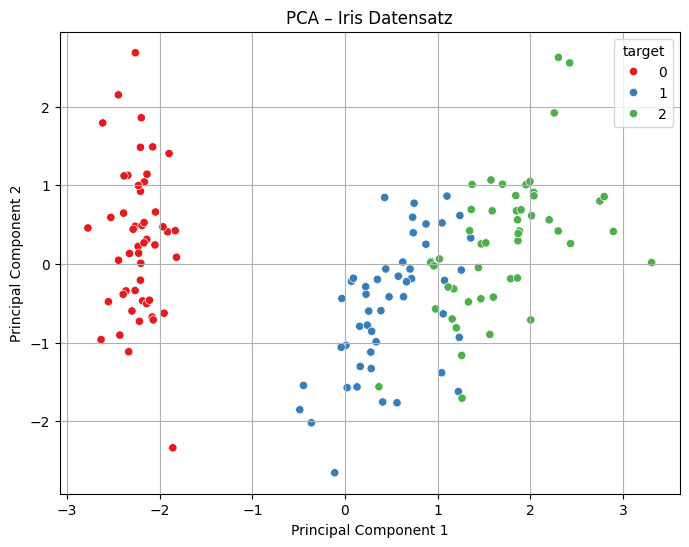

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["target"] = iris.target

# Visualisierung
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="target", data=pca_df, palette="Set1")
plt.title("PCA – Iris Datensatz")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


Erklärte Varianz: [0.72962445 0.22850762]
Kumulierte Varianz: [0.72962445 0.95813207]


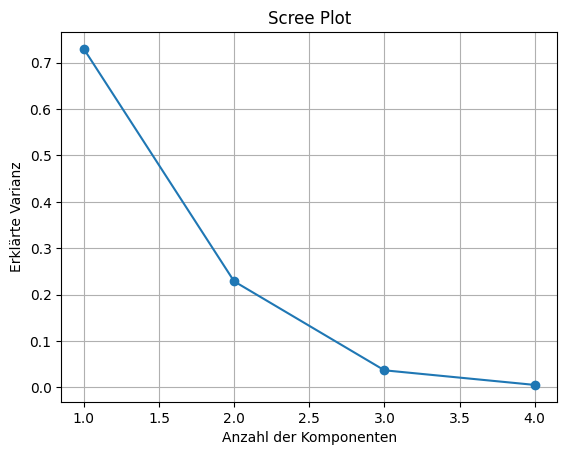

In [7]:
print("Erklärte Varianz:", pca.explained_variance_ratio_)
print("Kumulierte Varianz:", pca.explained_variance_ratio_.cumsum())

pca_full = PCA().fit(X_scaled)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_, marker='o')
plt.title("Scree Plot")
plt.xlabel("Anzahl der Komponenten")
plt.ylabel("Erklärte Varianz")
plt.grid(True)
plt.show()


# PCA on my Data

In [2]:
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
pd.options.display.max_columns = None


plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})

OCEAN_POINTS = 30
ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

../data/numerical_data/points30
../data/numerical_data/points10


In [ ]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                      start_time=df_ocean['time'].min(),
                                      end_time=df_ocean['time'].max(),
                                      verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)


def feature_engineering(df_ocean, df_weather, df_insitu):
    """
    Funktion zur Berechnung der u- und v-Komponenten des Windes aus der Windgeschwindigkeit und -richtung.
    """
    
    # df_weather


    #Calculate Radial Wind Speed
    theta = np.deg2rad(df_weather['wind_direction_10m'])

    #Calculate u and v components
    #    Definition der u- und v-Komponenten:
    #    u = Windgeschwindigkeit * sin(Windrichtung)
    #    v = Windgeschwindigkeit * cos(Windrichtung)
    df_weather['wind_u'] = df_weather['wind_speed_10m'] * np.sin(theta)  # positiver Wert = Wind nach Osten
    df_weather['wind_v'] = df_weather['wind_speed_10m'] * np.cos(theta)  # positiver Wert = Wind nach Norden

    # Remove the original wind speed and direction columns
    df_weather.drop(columns=['wind_speed_10m', 'wind_direction_10m'], inplace=True)

    return df_ocean, df_weather, df_insitu


df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)


def convert_df_to_table(df: pd.DataFrame) -> pd.DataFrame:


    df['position'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
    coordinates = df['position'].unique()

    df_merged = pd.DataFrame({'time': df['time'].unique()})
    for i in tqdm(range(len(coordinates)), desc="Processing coordinates", unit="coord", total=len(coordinates)):

        df_sub_data = df[df['position'] == coordinates[i]]
        df_sub_data = df_sub_data.drop(columns=['latitude', 'longitude'])

        cols = df_sub_data.columns.tolist()
        cols.remove('position')
        cols.remove('time')


        for col in cols:
            df_sub_data.rename(columns={col: col + '#' + str(coordinates[i])}, inplace=True)

        df_sub_data = df_sub_data.drop(columns='position')


        df_merged = df_merged.merge(df_sub_data, on='time')
        
    return df_merged

df_ocean_table = convert_df_to_table(df_ocean)
df_weather_table = convert_df_to_table(df_weather)


def merge_dataframes(dfs: list) -> pd.DataFrame:
    """
    Merge multiple DataFrames on the 'time' column.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='time', how='inner')

    merged_df['time'] = pd.to_datetime(merged_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return merged_df


df_merged = merge_dataframes([df_ocean_table, df_weather_table, df_insitu])

In [10]:
df_merged.head()

time  bottomT#(55.12493133544922, 12.56934642791748)  \
0  2022-12-03 00:00:00                                        7.879676   
1  2022-12-03 01:00:00                                        7.887771   
2  2022-12-03 02:00:00                                        7.890751   
3  2022-12-03 03:00:00                                        7.896270   
4  2022-12-03 04:00:00                                        7.902933   

   mlotst#(55.12493133544922, 12.56934642791748)  \
0                                      14.649431   
1                                      14.657304   
2                                      16.498772   
3                                      16.501226   
4                                      16.500742   

   siconc#(55.12493133544922, 12.56934642791748)  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   sithick#(55.12493133544922, 12.56934642791748)  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   sla#(55.12493133544922, 12.56934642791748)  \
0                                   -0.086606   
1                                   -0.074718   
2                                   -0.053600   
3                                   -0.050303   
4                                   -0.050954   

   so#(55.12493133544922, 12.56934642791748)  \
0                                   8.395580   
1                                   8.380219   
2                                   8.372637   
3                                   8.365764   
4                                   8.355705   

   sob#(55.12493133544922, 12.56934642791748)  \
0                                    9.989234   
1                                    9.974635   
2                                    9.964850   
3                                    9.951563   
4                                    9.934854   

   thetao#(55.12493133544922, 12.56934642791748)  \
0                                       8.538280   
1                                       8.526820   
2                                       8.513932   
3                                       8.508351   
4                                       8.503732   

   uo#(55.12493133544922, 12.56934642791748)  \
0                                  -0.069994   
1                                  -0.079356   
2                                  -0.080955   
3                                  -0.076369   
4                                  -0.072867   

   vo#(55.12493133544922, 12.56934642791748)  \
0                                  -0.143830   
1                                  -0.127434   
2                                  -0.126504   
3                                  -0.133716   
4                                  -0.139117   

   wo#(55.12493133544922, 12.56934642791748)  \
0                              -2.620675e-06   
1                              -8.750375e-07   
2                              -8.495825e-07   
3                              -9.131213e-07   
4                              -9.633662e-07   

   bottomT#(55.12493133544922, 16.04155731201172)  \
0                                        9.314838   
1                                        9.288813   
2                                        9.260718   
3                                        9.231033   
4                                        9.200737   

   mlotst#(55.12493133544922, 16.04155731201172)  \
0                                      16.509672   
1                                      18.548052   
2                                      18.547976   
3                                      18.

In [14]:
from sklearn.preprocessing import StandardScaler

df = df_merged.copy()

X = df.drop(columns=['time', 'slev'])
y = df['slev']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2021] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [509] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2021] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[509]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 509 Principal Components explain [95.03%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

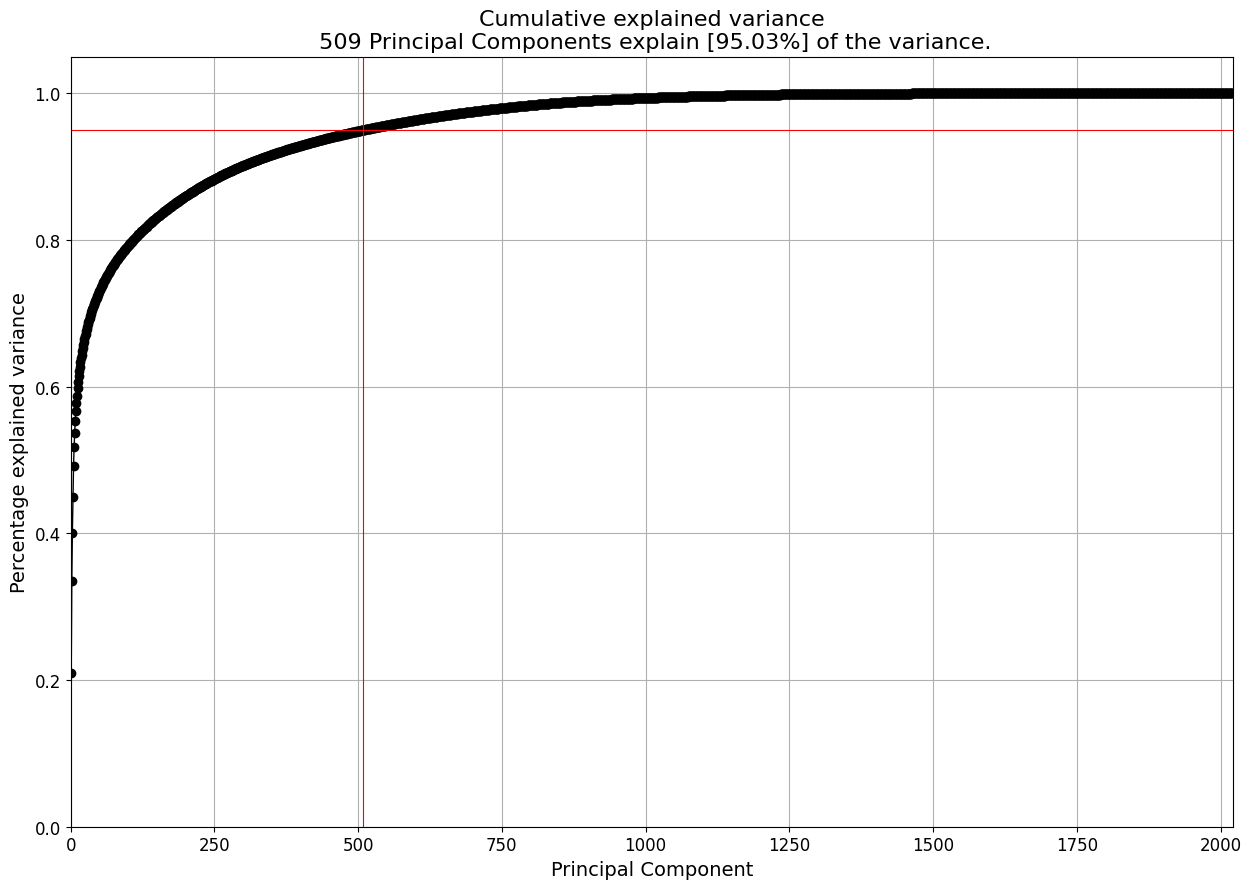

In [15]:
from pca import pca 
# PCA anwenden
model = pca()
results = model.fit_transform(X_scaled)

# Scree Plot + PCA Scatter Plot automatisch anzeigen
model.plot()